# Tutorial 4: Working with Geometries

cendat can fetch geographic boundaries alongside your data for mapping.

**Goal:** Get median household income data with geometries for Colorado block groups and create a choropleth map.

## Setup

In [8]:
import os
import matplotlib.pyplot as plt
from cendat import CenDatHelper
from dotenv import load_dotenv

load_dotenv()
cdh = CenDatHelper(key=os.getenv("CENSUS_API_KEY"))

✅ API key loaded successfully.


## Step 1: Select Product

In [9]:
cdh.list_products(years=[2023], patterns=r"acs/acs5\)")
cdh.set_products()

✅ Product set: 'ACS 5-Year Detailed Tables (2023/acs/acs5)' (Vintage: [2023])


## Step 2: Select Variables and Geography

In [10]:
# Search for median household income groups
cdh.list_groups(patterns=r"^median household income")

[{'name': 'B29004',
  'description': 'Median Household Income for Households With a Citizen, Voting-Age Householder (in 2023 Inflation-Adjusted Dollars)',
  'product': 'ACS 5-Year Detailed Tables (2023/acs/acs5)',
  'vintage': [2023],
  'url': 'http://api.census.gov/data/2023/acs/acs5'},
 {'name': 'B19013H',
  'description': 'Median Household Income in the Past 12 Months (in 2023 Inflation-Adjusted Dollars) (White Alone, Not Hispanic or Latino Householder)',
  'product': 'ACS 5-Year Detailed Tables (2023/acs/acs5)',
  'vintage': [2023],
  'url': 'http://api.census.gov/data/2023/acs/acs5'},
 {'name': 'B19013I',
  'description': 'Median Household Income in the Past 12 Months (in 2023 Inflation-Adjusted Dollars) (Hispanic or Latino Householder)',
  'product': 'ACS 5-Year Detailed Tables (2023/acs/acs5)',
  'vintage': [2023],
  'url': 'http://api.census.gov/data/2023/acs/acs5'},
 {'name': 'B19013B',
  'description': 'Median Household Income in the Past 12 Months (in 2023 Inflation-Adjusted

In [11]:
cdh.set_groups(["B19013"])
cdh.describe_groups()

✅ Groups set: B19013

--- Group: B19013 (Median Household Income in the Past 12 Months (in 2023 Inflation-Adjusted Dollars)) ---

  Product: ACS 5-Year Detailed Tables (2023/acs/acs5) (Vintage: 2023)
      B19013_001E: Median household income in the past 12 months (in 2023 inflation-adjusted dollars)


In [12]:
# 150 = Block Groups
cdh.set_geos(["150"])

✅ Geographies set: 'block group' (requires `within` for: county, state, tract)


## Step 3: Get Data with Geometry

In [13]:
# Fetch data for 3 Colorado counties with geometries
response = cdh.get_data(
    include_names=True,
    include_geometry=True,  # This fetches boundaries from TIGERweb
    within={
        "state": ["08"],  # Colorado
        "county": ["069", "123", "013"],  # Larimer, Weld, Boulder
    },
)

✅ Variables set:
  - Product: ACS 5-Year Detailed Tables (2023/acs/acs5) (Vintage: [2023])
    Variables: B19013_001E
✅ Parameters created for 1 geo-variable/group combinations.
✅ Data fetching complete. Stacking results.
✅ Geometry fetching complete. Stacking results.


## Step 4: Convert to GeoDataFrame and Map

In [14]:
# to_gpd() returns a GeoDataFrame ready for mapping
gdf = response.to_gpd(destring=True, join_strategy="inner")

# Handle missing values (Census uses -666666666 for suppressed data)
gdf.loc[gdf["B19013_001E"] == -666666666, "B19013_001E"] = None

print(f"Block groups returned: {len(gdf)}")
gdf.head()

Block groups returned: 669


,NAME,GEO_ID,B19013_001E,B19013_001EA,B19013_001M,B19013_001MA,state,county,tract,block group,GEOID,geometry,product,vintage,sumlev,desc
0,Block Group 1; Census Tract 19.05; Weld County...,1500000US081230019051,114333.0,None,23010,None,08,123,001905,1,081230019051,"POLYGON ((-104.80157 40.08309, -104.8012 40.08...",ACS 5-Year Detailed Tables (2023/acs/acs5),2023,150,block group
1,Block Group 2; Census Tract 19.05; Weld County...,1500000US081230019052,34250.0,None,12371,None,08,123,001905,2,081230019052,"POLYGON ((-104.81053 40.08671, -104.81053 40.0...",ACS 5-Year Detailed Tables (2023/acs/acs5),2023,150,block group
2,Block Group 3; Census Tract 19.05; Weld County...,1500000US081230019053,74052.0,None,30102,None,08,123,001905,3,081230019053,"POLYGON ((-104.81055 40.09454, -104.81055 40.0...",ACS 5-Year Detailed Tables (2023/acs/acs5),2023,150,block group
3,Block Group 1; Census Tract 19.06; Weld County...,1500000US081230019061,74063.0,None,12646,None,08,123,001906,1,081230019061,"POLYGON ((-104.8862 40.12156, -104.8862 40.121...",ACS 5-Year Detailed Tables (2023/acs/acs5),2023,150,block group
4,Block Group 1; Census Tract 20.18; Weld County...,1500000US081230020181,142338.0,None,14844,None,08,123,002018,1,081230020181,"POLYGON ((-104.98033 40.13875, -104.98033 40.1...",ACS 5-Year Detailed Tables (2023/acs/acs5),2023,150,block group


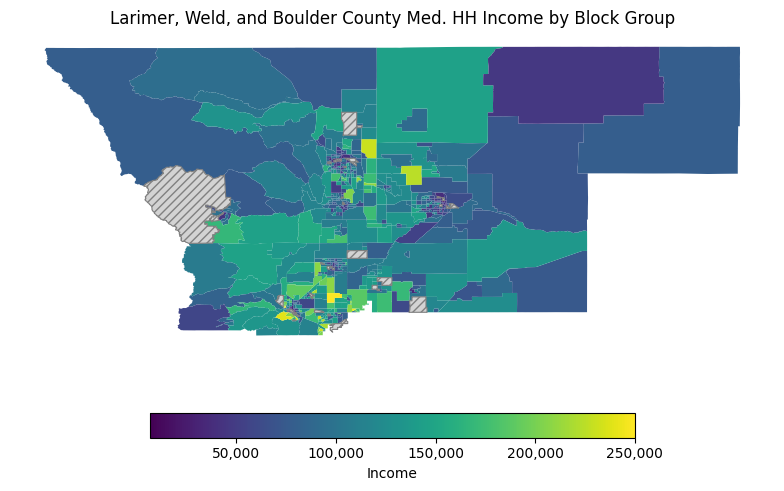

In [17]:
# Create a polished choropleth map
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

gdf.plot(
    column="B19013_001E",
    cmap="viridis",
    linewidth=0.8,
    ax=ax,
    legend=True,
    alpha=1.0,
    legend_kwds={
        "label": "Income",
        "orientation": "horizontal",
        "location": "bottom",
        "shrink": 0.5,
        "fraction": 0.1,
        "format": "{x:,.0f}",
    },
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "grey",
        "hatch": "////",
        "label": "Missing values",
    },
)

ax.set_title(
    "Larimer, Weld, and Boulder County Med. HH Income by Block Group",
    fontdict={"fontsize": "12", "fontweight": "3"},
)
ax.set_axis_off()
plt.tight_layout()
plt.show()

> **Note - Supported Geographies**
>
> Geometry fetching currently supports: regions (020), divisions (030), states (040), counties (050), county subdivisions (060), census tracts (140), block groups (150), and places (160).